In [1]:
# using Pkg; Pkg.add.(["CSV", "DataFrames", "RDatasets", "StatsPlots"])
using LinearAlgebra, Statistics, CSV, DataFrames, RDatasets, Random, Plots, StatsPlots, LaTeXStrings, Latexify

Random.seed!(1228)
# ----------------------------------------------------------------------------
function error_concentration_ellipse( Σ, q; μ=[0,0], n_std=1, pts=40)
    # compute points on an ellipse
    #    Σ  : (length of major axis, length of minor axis)
    #    V  : matrix [ q1 q2 ], where q1 and q2 are orthonormal vectors along the major and minor axes of the ellipse respectively
    #    μ  : (x₀, y₀)  center of the ellipse

    function pts_on_ellipse( ax; angle=0, center=0, pts=40)
        ϕ   = range(0,stop=2π,length=pts)
        c   = cos(angle); s = sin(angle)
        Pts = [ax[1]*cos.(ϕ) ax[2]*sin.(ϕ)] *  [c s; -s c]
        (Pts[:,1], Pts[:,2])
    end

    ax    = n_std*Σ
    θ     = atan(q[2], q[1])

    pts_on_ellipse( ax; angle=θ, center = μ, pts=pts )
end;

<div style="float:center;width:100%;text-align: center;"><strong style="height:60px;color:darkred;font-size:40px;">2D PCA Example</strong></div>

# 1. Introduction

## 1.1 Summary

This notebook focuses on the bases obtained by the SVD for a matrix
$A = U \Sigma V^t$ of size $M \times N$ of rank $r$, i.e.,
* the **row space basis** $\{\;v_1, v_2, \dots v_r \;\}$ (the first $r$ columns of $V$)
* the **column space basis** $\{\;u_1, u_2, \dots u_r \;\}$ (the first $r$ columns of $U$)

**Statistical Interpretation:**

Assume the **rows** of the matrix $A$ are measurements of a set of $\mathbf{N}$ **features**<br>
$\qquad$ e.g., the petal length and petal width of a particular iris plant.<br>
$\qquad$ each **column** of the matrix therefore lists **all $\mathbf{M}$ measurements** of a particular feature.

In statistics, the features are demeaned [see the Mean and Standard Projections Notebook](MeanAndStdProjections.ipynb).

The (scaled) [Gram Matrix](26_GramMatrix.ipynb) of $A$ is the **covariance matrix** of the features:
$$cov(A) = \frac{1}{N-1} A^t A$$ 

* Since $A^t A = V \Sigma^t \Sigma V^t \Leftrightarrow \Sigma^t \Sigma = V^t A^t A V$, the SVD<br>$\qquad$ yields a diagonalization $\Sigma^t \Sigma$ of the covariance matrix<br>
$\qquad$ obtained by changing the coordinate basis to the singular vectors,<br>$\qquad$ i.e., the columns of $V$.
<br>
Note that $\Sigma^t \Sigma = V^t A^t A V$ is the Rayleigh Coefficient of the Gram matrix $A^t A$<br>$\qquad$ evaluated at each of the eigenvalues $\sigma_i^2$ of this matrix.

* The vectors $u_i = \frac{1}{\sigma_i} A v_i$ are linear combinations of the feature vectors:<br>
$\qquad$ in column view
$\sigma_i u_1 = v_{i,1}\ a_1 + v_{i,2}\ a_2 + \dots v_{i,N}\ a_n$<br>
$\qquad$ a weighted sum of the original features, with coefficients<br>$\qquad$ corresponding to the entries of $v_i$.<br><br>
$\qquad$ The $u_i$ are the **principal components** of the feature matrix $A$.

**Reminder:**
* The principal components (the columns of the $U$ matrix) are unit length and mutually orthogonal
* The ordering of the principal components is by importance, as measured by the eigenvalues $\sigma_i^2$ of the covariance matrix,<br>
  where $\sigma_1 \ge \sigma_2 \ge \dots \sigma_r$ 

## 1.2 Problem Statement

If we consider a row of measurements from $A$ as a point in $\mathbb{R}^N$, we can consider the graph of the measurements as points with coordinates corresponding to the features in our data set.

**PCA (Principal Component Analysis):**<br>$\qquad$ find a line through the origin that **maximizes** the variance of the orthogonal projections<br>$\qquad$ of the data onto this line, i.e.,<br>$\qquad$ the **square of the euclidean distance** of the projected points from the origin

**Reminder:**
* The equation of a line through the origin with unit lenght direction vector $\tilde{v}$ is given by<br>
$\qquad p = \alpha v$ for all $\alpha \in \mathbb{R}$.
* The orthogonal projection of a vector $b$ onto this line is given by $b_\parallel = \left(\tilde{v} \cdot b\right)\ \tilde{v}$.

[Geogebra Application: explore the effect of changing the direction of the line](https://www.geogebra.org/classic/tuymps5c)

<div style="padding:15pt;">
    <img src="Figs/PCA_SVD.svg" width=450 style="margin: 0% 0% 0px -5%;">
</div>

Two articles that may be of interest
* [PCA as an optimization problem](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)
* [PCA and total least squares](https://tungmphung.com/principal-component-analysis-fully-explained/)

# 2. A Small 2D Example

Consider the following data set, consisting of two feature vectors $x_1$ and $x_2$ arranged in a matrix $A$ as **columns**:<br>$\qquad$  $A = \left( x_1 \; x_2 \right)$.

In [2]:
function create_2D_data(N)
    x = 10randn(N)
    y = 0.1x .* x .+ 2x .+ 1 .+ 15rand(N)
    [x.-mean(x)  y.-mean(y)]
end;

N = 300
A = create_2D_data(N);
println("the last 4 rows of A are")
latexify(round.(A[end-4:end, :], digits=3))

the last 4 rows of A are


L"\begin{equation}
\left[
\begin{array}{cc}
5.884 & 12.599 \\
5.762 & 3.555 \\
-6.368 & -15.291 \\
20.745 & 84.742 \\
-4.864 & -20.094 \\
\end{array}
\right]
\end{equation}
"

When we plot the measurements $x_2$ versus $x_1$, we see that the data vectors are highly correlated:

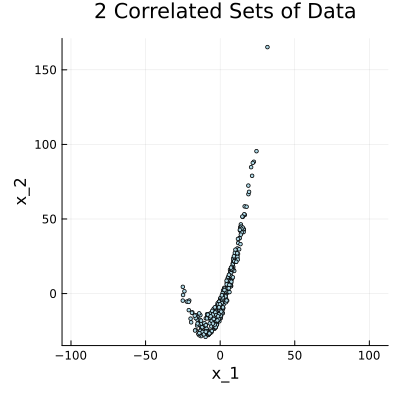

In [3]:
scatter(A[:,1], A[:,2], legend=:none, aspect_ratio=:equal,
        ms=2, mc="lightblue", title="2 Correlated Sets of Data", size=(400,400),
       xlabel="x_1", ylabel="x_2" )

# 1. Singular Vectors $V_r$ and Singular Values  $\Sigma$

The following theorem states that the maximum variance of the data set is $\frac{\sigma_1^2}{N-1}$,<br>
$\qquad$ and is achieved when the direction vector of the line is the singular vector $v_1$.

Each additional singular vector in turn then provides the maximum remaining variance in the data.

<div style="float:left;width:100%;background-color:#F2F5A9;color:black;">

**Theorem:** Given a matrix $A \in \mathbb{R}^{M \times N}$ with reduced SVD $A = U_r \Sigma_r V^t_r$. Then

$\quad$ $\sigma^2_1 = \quad \underset{\lVert q \rVert = 1}{\operatorname{max}}\;\; q^t A^t\ A\ q$, 
$\quad$ $\ v_1 = \; \underset{\lVert q \rVert = 1}{\operatorname{argmax}}\ q^t A^t\ A\ q$,<br>
<!-- -->
$\quad$ $\sigma^2_2 = \underset{\lVert q \rVert = 1, q \perp v_1}{\operatorname{max}}\ q^t A^t\ A\ q$, 
$\quad$ $v_2 = \underset{\lVert q \rVert = 1, q \perp v_1}{\operatorname{argmax}}\ q^t A^t\ A\ q$,<br>
$\quad \dots$ 
</div>

* The **principal directions** $\mathbf{v_i}$ are the singular vectors of $A$
* The singular values are the **standard deviations** of the data<br>
$\quad$ along the principal
directions (multiplied by $\sqrt{N-1}$).
* The SVD conveniently orders the directions and standard deviations from most important to least important: $\sigma_1 \ge \sigma_2 \ge \dots \sigma_r$.
* The singular values and vectors can be computed sequentially in order of their importance.

Standard Deviations along each axis: [27.4, 5.3] 



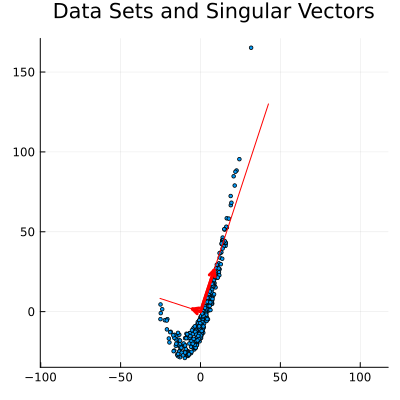

In [4]:
svdA    = svd(A)

V       = svdA.Vt'           # Singular Vectors of A (most significant is last)
σ       = svdA.S / sqrt(N-1) # Singular Values  of A (largest is last)
println("Standard Deviations along each axis: $(round.(σ, digits=1)) \n")
scatter(A[:,1], A[:,2], legend=:none, aspect_ratio=:equal, ms=2,
        title="Data Sets and Singular Vectors", size=(400,400) )
plot!([0; σ[1]*V[1,1]], [0; σ[1]*V[2,1]], arrow = true, color="red", lw=3)
plot!([0; σ[2]*V[1,2]], [0; σ[2]*V[2,2]], arrow = true, color="red", lw=3)
scale=5.0
plot!([0; scale*σ[1]*V[1,1]], [0; scale*σ[1]*V[2,1]], arrow = false, color="red", lw=1)
plot!([0; scale*σ[2]*V[1,2]], [0; scale*σ[2]*V[2,2]], arrow = false, color="red", lw=1)


Each successive component of the decomposition contributes to the total variance

$$
Total\ Variance = \frac{1}{N-1} trace(A^t A)
$$

**Remark:** For a given orthogonal matrix $Q$ of size $M \times M$,<br>
$\qquad$ $A^tA$ and $Q^t A^t A Q$ have the same eigenvalues:<br>
$\qquad$ a change of basis conserves the total variance.

σ and Cumulative Variance Explained



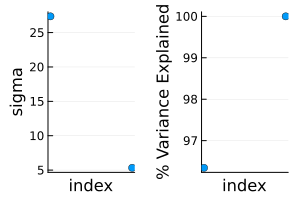

In [5]:
percent_variance_explained = 100cumsum(σ.^2) / sum(σ.^2)

p1 = scatter( σ,                          size=(300,200), label=:none, xlabel="index", ylabel="sigma",    xticks=:none )
p2 = scatter( percent_variance_explained, size=(300,200), label=:none, xlabel="index", ylabel="% Variance Explained", xticks=:none )
println( "σ and Cumulative Variance Explained\n")
plot( p1,p2 )

# 2. Error Concentration Ellipses

If the data is drawn from a Gaussian distribution, we can draw **error concentration ellipses**<br>
$\qquad$ capturing a percentage of the data:<br>
$\qquad\quad$ the ellipse axes are the singular vectors $v_1, v_2$,<br>
$\qquad\quad$ the major and minor axes are the singular values.

The following plot shows the ellipses at 1, 2 and 3 standard deviations

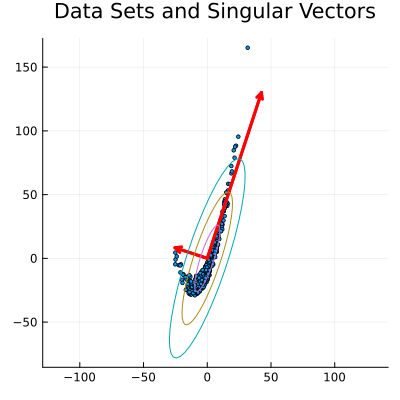

In [6]:
scatter(A[:,1], A[:,2], legend=:none, aspect_ratio=:equal, ms=2,
        title="Data Sets and Singular Vectors", size=(400,400) )
scale=5
plot!([0; scale*σ[1]*V[1,1]], [0; scale*σ[1]*V[2,1]], arrow = true, color="red", lw=3)
plot!([0; scale*σ[2]*V[1,2]], [0; scale*σ[2]*V[2,2]], arrow = true, color="red", lw=3)
plot!( error_concentration_ellipse( σ, svdA.V[:,1]; n_std=1))
plot!( error_concentration_ellipse( σ, svdA.V[:,1]; n_std=2))
plot!( error_concentration_ellipse( σ, svdA.V[:,1]; n_std=3))

# 3. Least Squares versus Total Least Squares

In **least squares,** we posit a model $y = f(x)$ and search for a minimal change to $y$ for a given fixed value $x$.

In **total least squares,** we allow both $x$ and $y$ to be changed. We will use fewer data points to show the differences more clearly.

In [7]:
using StatsBase
data    = A[sample(1:N, 10, replace = false),:];  # we will use just 10 values
x_1 = data[:,1]
x_2 = data[:,2];

#### Least Squares Problem

The least squares problem determines a linear relationship between the features,<br>
$\qquad$ e.g., a model $x_2 = \alpha + \beta x_1$<br>
$\qquad$ under the assumption that $x_1$ is fixed, while $x_2$ is considered in error:

we wish to change $x_2$ as little as possible such that the corrected values<br>
$\qquad$ fall on the conjectured line.

Formulating the problem leads to the **least squares solution** of<br>
$\qquad\left( \mathbf{1} \; x_1 \right) x = b$,<br>
$\qquad$ where $x = \begin{pmatrix}\alpha \\ \beta \end{pmatrix}$, and $\mathbf{1}$ is the vector with all entries equal to 1. 


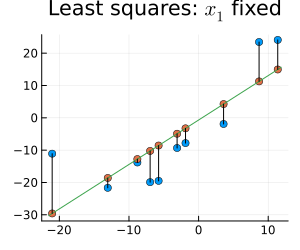

In [8]:
# Least squares solution for the model x_2 = \alpha + \beta x_1

D            = [ ones(10) x_1 ]
coeffs       = pinv(D) * x_2            # solve the least squares pb using the pseudo-inverse
x_2_estimate = D * coeffs
f(x)         = coeffs[1] + coeffs[2]*x  # equation of the estimated model line

scatter( (data[:,1],data[:,2]), label=:none, size=(300,250), title="Least squares: "*L"x_1 "*" fixed" )
scatter!( (data[:,1], x_2_estimate ), label = :none)
min_x_1 = min(x_1...)-0.5; max_x_1 = max(x_1...)+0.5
plot!( ([min_x_1, max_x_1], [f(min_x_1), f(max_x_1)]), label=:none)
for i in 1:10
    plot!( ([x_1[i], x_1[i]], [x_2[i], x_2_estimate[i]]), label=:none, color="black")
end
plot!()

This is a **vertical projection** of each row of $\left( x_1 \; x_2 \right)$ onto the best fit line.

The algorithm **minimizes the sum of distances** from the original point<br>
$\qquad$ to the **vertical projection** onto the line.

#### Total Least Squares Problem

The total least squares problem by contrast considers both $x_1$ and $x_2$ to be in error:<br>
$\qquad$ We again assume that the data should fall on a line $\alpha x_1 + \beta x_2 = 0$,<br>
$\qquad$ (the data are assumed to have mean 0)<br>
$\qquad$ we want to change $x_1$ and $x_2$ as little as possible so that the resulting estimated values fall on a line.

A formulation of this problem leads to the SVD of the matrix $A = \left( x_1 \; x_2 \right)$<br>
$\qquad$ where $A = U \Sigma V^t$, where the direction vector $\begin{pmatrix}\alpha \\ \beta \end{pmatrix} = v_1$, the first column of the $V$ matrix.

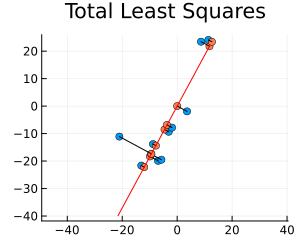

In [9]:
dataSVD = svd(data)
q_1     = dataSVD.V[:,1]

slope   = q_1[2]/q_1[1]
f(x)    = slope*x                        # the line (passes through the origin since the data are demeaned)

projections = [ p * q_1 for p in (data * q_1) ]  # (v ⋅ q₁) q₁

scatter( (data[:,1],data[:,2]), aspect_ratio=:equal, label=:none, size=(300,250), title="Total Least Squares" )
for i in 1:10
    scatter!( (projections[i][1], projections[i][2]), label=:none, color="coral")
    plot!(([x_1[i], projections[i][1]], [x_2[i], projections[i][2]]), label=:none, color="black")
end
plot!([min_x_1; max_x_1], [f(min_x_1); f(max_x_1)], arrow = false, color="red", lw=1, label=:none)

This is an **orthogonal projection** of each row of $\left( x_1 \; x_2 \right)$ onto the best fit line.

The algorithm **minimizes the sum of distances** from the original point<br>
$\qquad$ to the **orthogonal projection** onto the line.

# 4. Dimensionality Reduction

We now consider the basis $\{\; u_1, u_2, \dots u_N \;\}$ of the column space of $A$ (the columns of the $U$ matrix.

$\qquad
    u_i = \frac{1}{\sigma_i} A v_i
$

Rewriting $A v_i$ in column view, we see that $\quad A v_i = \sigma_i u_i = v_{i 1}\ a_1 +  v_{i 2}\ a_2 + \dots  v_{i N}\ a_N$,<br>
$\qquad$ i.e., the vectors $u_i$ are linear combinations of the feature vectors.

The vectors $t_i = \sigma_i u_i$ are the **principal components** of the feature vectors.

Properties of the principal components are
* the vectors $t_i$ are uncorrelated since $u_i ⋅ u_j = 0$ for $i \ne j$.
* the autocorrelation of these vectors is $\sigma_i^2$, the maximum variance we found using the singular vectors $v_i$ since the vectors $u_i$ are unit length.
* the vectors are ordered by their relative importance: $\Vert t_1 \Vert \ge \Vert t_2 \Vert \ge \Vert t_r \Vert.$
* the vectors have zero mean since $\mathbf{1}^t T = \mathbf{1}^t A V = 0$ since the columns of $A$ have zero mean

In [10]:
T = A * svdA.V

println("Checks:")
println("* The size of the PA component matrix is $(size(T))")

println( "* We can recover the original feature vectors from the principal components:")
@show T * svdA.Vt ≈ A
println("\n* The principal components are orthogonal")
@show round(T[:,1]⋅T[:,2], digits=3)

println("\n* The principal components have zero mean")
@show round.(mean(A, dims=1), digits=10);

Checks:
* The size of the PA component matrix is (300, 2)
* We can recover the original feature vectors from the principal components:
T * svdA.Vt ≈ A = true

* The principal components are orthogonal
round(T[:, 1] ⋅ T[:, 2], digits = 3) = 0.0

* The principal components have zero mean
round.(mean(A, dims = 1), digits = 10) = [-0.0 -0.0]


In [11]:
println("The norm of the principal components are the eigenvalues AᵗA")
println("Eigenvalues: $(round.(svdA.S, digits=3))")
println("TᵗT        = "); display( latexify(round.(sqrt.(abs.(T'T)), digits=3)))

println( "It may be advantageous in further analysis to scale out the eigenvalues (Normalization)");

The norm of the principal components are the eigenvalues AᵗA
Eigenvalues: [473.145, 92.169]
TᵗT        = 


L"\begin{equation}
\left[
\begin{array}{cc}
473.145 & 0.0 \\
0.0 & 92.169 \\
\end{array}
\right]
\end{equation}
"

It may be advantageous in further analysis to scale out the eigenvalues (Normalization)


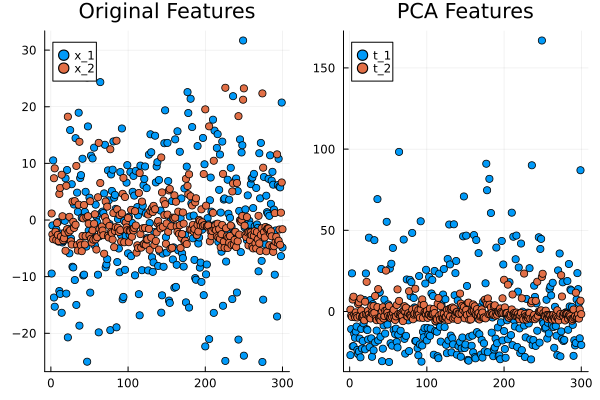

In [12]:
p1 = scatter(A[:,1],label="x_1", title="Original Features")
scatter!(T[:,2], label="x_2")
p2 = scatter(T[:,1], label="t_1", title="PCA Features")
scatter!(T[:,2], label="t_2")
plot(p1,p2)
#scatter!(A[:,1])

Since the principal components are ordered by their relative importance,<br>
$\qquad$ we may **consider only the first $\mathbf{k}$ components** and work with this reduced PCA feature set<br>
$\qquad$ to analyze a problem.

**Advantages of PCA:**
* Removes correlated features
* Allows for easier visualization
* Helps reducing overfitting

**Disadvantages:**
* Variables become less interpretable
* Information is lost when $t_i, i = k+1, \dots r$ are discarded
* Data standardization may be required

# 2. A Larger Example

In [13]:
iris     = dataset("datasets", "iris")
features = collect(Matrix(iris[:, 1:4]))
iris[end-2:end,:]

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,6.5,3.0,5.2,2.0,virginica
2,6.2,3.4,5.4,2.3,virginica
3,5.9,3.0,5.1,1.8,virginica


There are 4 Features: they would be represented by points in $\mathbb{R}^4$.

To draw these we will have to look at sets of either 2 or 3 features!

In [14]:
plotlyjs()

p1 = @df iris scatter3d( :PetalLength, :PetalWidth, :SepalLength,
    group = :Species, label=:none, ms = 1, size=(420,420),
    title = "Petal Length, Petal Width and Sepal Length" )

WebIO._IJuliaInit()

In [15]:
# PCA analysis
svdFeatures = svd(features)
V           = svdFeatures.Vt'           # Singular Vectors of A (most significant is last)
σ           = svdFeatures.S / sqrt(N-1) # Singular Values  of A (largest is last)
T           = features * V

# add the features to the iris dataset for convenience
iris[!,:t1]=T[:,1]
iris[!,:t2]=T[:,2]
iris[!,:t3]=T[:,3]
iris[!,:t4]=T[:,4]

println( "variances sigma^2 = $(round.(svdFeatures.S,digits=2))" )

variances sigma^2 = [95.96, 17.76, 3.46, 1.88]


σ and Cumulative Variance Explained



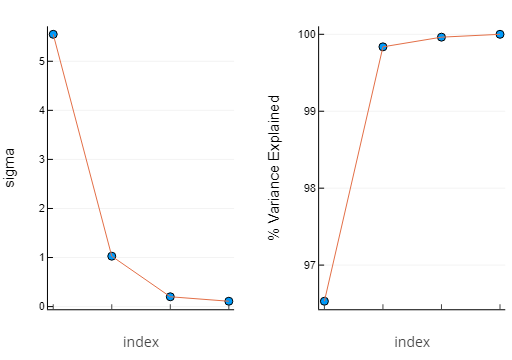

In [16]:
percent_variance_explained = 100cumsum(σ.^2) / sum(σ.^2)

p1 = scatter( σ,                          size=(300,200), label=:none, xlabel="index", ylabel="sigma",    xticks=:none )
plot!(σ, label=:none)
p2 = scatter( percent_variance_explained, size=(300,200), label=:none, xlabel="index", ylabel="% Variance Explained", xticks=:none )
plot!(percent_variance_explained, label=:none)
println( "σ and Cumulative Variance Explained\n")
plot( p1,p2 )

In [17]:
p1=@df iris scatter3d( :t1, :t2, :t3,
    group = :Species, label = :none, ms = 1, size=(400,400), title="3 PCA features" );

p2 = @df iris scatter( :t1, :t2,
    group = :Species, label=:none, ms = 2, size=(400,400), title="2 PCA features" );

plot(p1,p2)